# Evaluate CRNN

In [1]:
from src.model.vit import CaptchaModelViT
from src.utils.dataset import CaptchaDataset
from src.utils.utils import batchOnehotEncodeLabel, batchDecodeCTCOutput

import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader

import os
from tqdm import tqdm

load dataset

In [2]:
transforms = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.ToDtype(torch.float32, scale=True),
])

train_ds = CaptchaDataset('dataset', split='train', transform=transforms)
valid_ds = CaptchaDataset('dataset', split='valid', transform=transforms)
test_ds = CaptchaDataset('dataset', split='test', transform=transforms)

load model

In [3]:
chkpt_dir = './checkpoints/train_vit/'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [4]:
model = CaptchaModelViT()
model.load_state_dict(torch.load(os.path.join(chkpt_dir, 'checkpoint_2900.pth'))['model_state_dict'])
model.to(device)
model.eval()

CaptchaModelViT(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pe): PositionalEncoding()
  (transformerLayer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=

Evaluate Model

In [5]:
BATCH_SIZE = 1024
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [6]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
def getAccuracy(model, dl, n_wrong_samples=10):
    with torch.no_grad():
        model.eval()
        total = 0
        correct = 0
        partial_correct = 0
        wrong_samples = []
        for i, (x, yStr) in tqdm(enumerate(dl), total=len(dl)):
            x, y = x.to(device), batchOnehotEncodeLabel(yStr).to(device)

            # forward pass
            output = model(x)
            # get predicted labels
            predStr = batchDecodeCTCOutput(output)

            # compute accuracy
            total += len(yStr)
            for j, (pred, label) in enumerate(zip(predStr, yStr)):
                if pred == label:
                    correct += 1
                elif len(wrong_samples) < n_wrong_samples:
                    wrong_samples.append((x[j].detach().cpu().numpy(), label, pred))
                for c in range(5):
                    if c < len(pred) and pred[c] == label[c]:
                        partial_correct += 0.2
        print(f'Total Accuracy: {correct / total}')
        print(f'Partial Accuracy: {partial_correct / total}')
        return wrong_samples

In [17]:
wrong_samples = []
wrong_samples.extend(getAccuracy(model, train_dl))
wrong_samples.extend(getAccuracy(model, valid_dl))

 17%|█▋        | 4/24 [00:04<00:22,  1.11s/it]


KeyboardInterrupt: 

visualize several mistaken samples

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
def plotSamples(samples):
    fig, axs = plt.subplots(len(samples), 1, figsize=(20, 5 * len(samples)))
    for i, (x, label, pred) in enumerate(samples):
        axs[i].imshow(x.reshape(60, 160), cmap='gray')
        axs[i].set_title(f'Label: {label}, Pred: {pred}')
        axs[i].axis('off')
    plt.show()

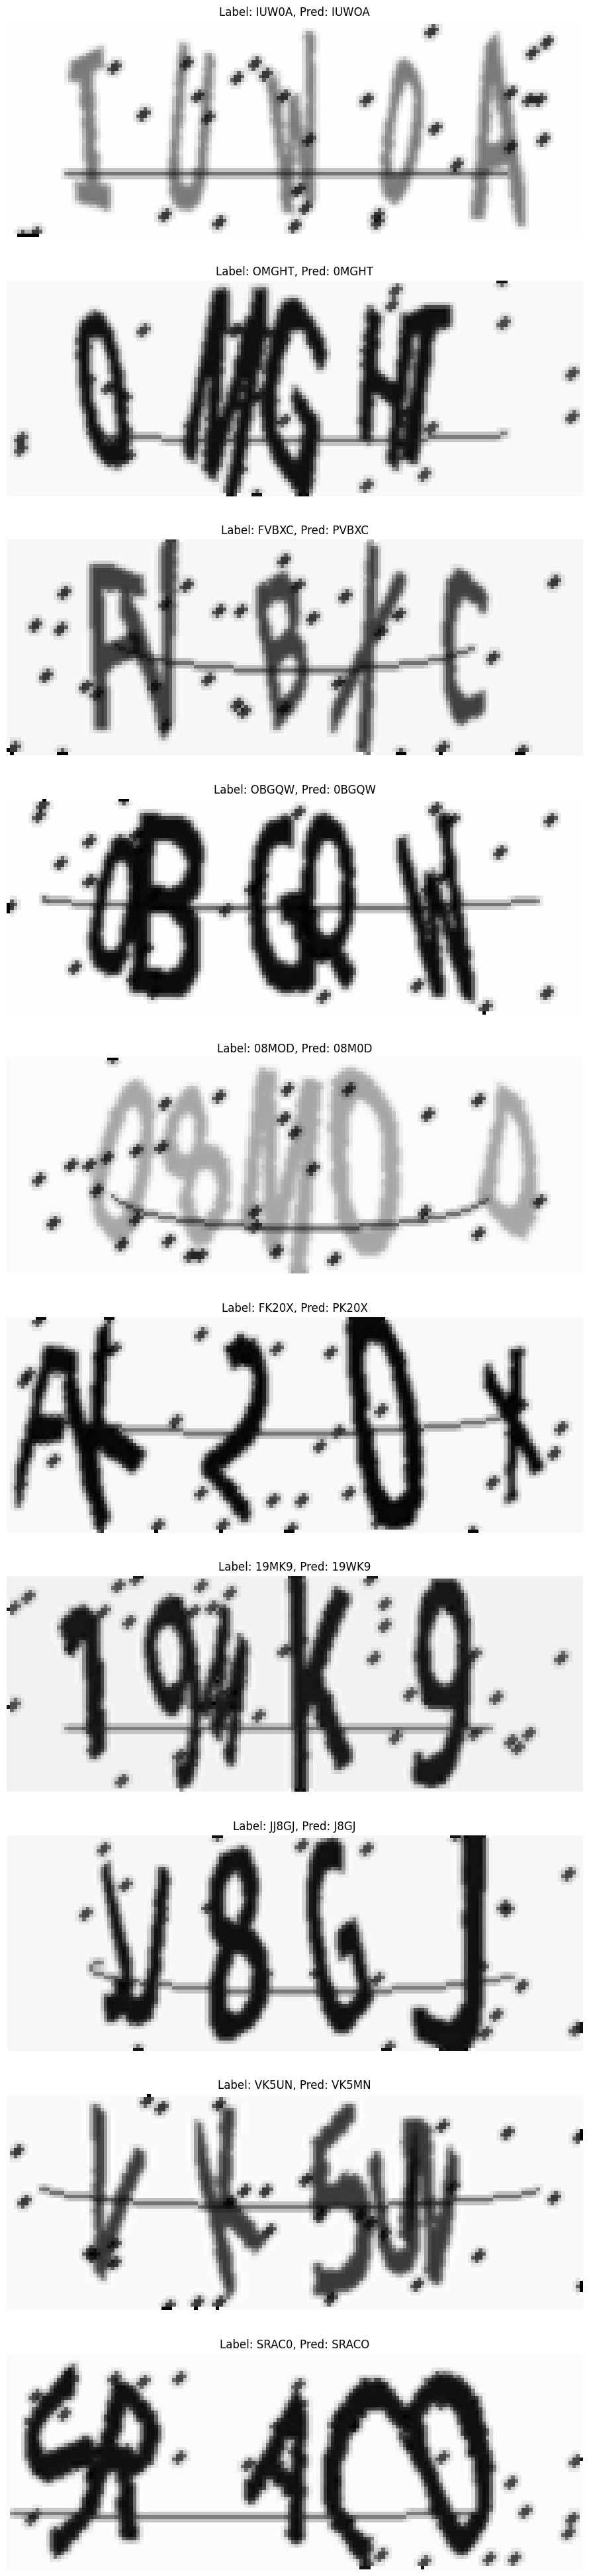

In [ ]:
plotSamples(wrong_samples)

### Prediction on Test Dataset

In [8]:
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
for x, y in test_dl:
    print(x.shape)
    print(y)
    break

torch.Size([1024, 1, 60, 160])
('5730.png', '41.png', '290.png', '8627.png', '3844.png', '1425.png', '7660.png', '2724.png', '3886.png', '8625.png', '6999.png', '5413.png', '1139.png', '7388.png', '4567.png', '9004.png', '1028.png', '7460.png', '5264.png', '2970.png', '7591.png', '4949.png', '7233.png', '5685.png', '4930.png', '3541.png', '7985.png', '4149.png', '2600.png', '7617.png', '7246.png', '5783.png', '9545.png', '6603.png', '4876.png', '922.png', '9848.png', '9972.png', '1474.png', '4629.png', '3208.png', '8415.png', '971.png', '8816.png', '1803.png', '3716.png', '4485.png', '4775.png', '7829.png', '2537.png', '5048.png', '902.png', '5071.png', '4701.png', '3420.png', '8286.png', '7486.png', '5433.png', '5718.png', '4359.png', '3219.png', '9498.png', '1337.png', '3291.png', '9193.png', '5292.png', '8241.png', '7320.png', '6008.png', '2662.png', '9742.png', '3634.png', '5461.png', '7844.png', '5067.png', '8928.png', '5626.png', '7946.png', '5601.png', '6555.png', '8802.png', '2

In [10]:
import csv

In [11]:
with open('submission.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['image_name', 'captcha_text'])
    with torch.no_grad():
        model.eval()
        total = 0
        correct = 0
        partial_correct = 0
        wrong_samples = []
        for i, (x, fname) in tqdm(enumerate(test_dl), total=len(test_dl)):
            x = x.to(device)

            # forward pass
            output = model(x)
            # get predicted labels
            predStr = batchDecodeCTCOutput(output)
            writer.writerows(zip(fname, predStr))


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]
